In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dog-breed-identification
!unzip -q dog-breed-identification.zip

In [ ]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("labels.csv")
print(df.shape)
df.head()

(10222, 2)


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [5]:
top_labels = df["breed"].value_counts().nlargest(20).index.tolist()
filtered_df = df[df["breed"].isin(top_labels)]
filtered_df = filtered_df.reset_index(drop=True)
print(filtered_df.shape)
filtered_df.head()

(2184, 2)


id               breed
0  003df8b8a8b05244b1d920bb6cf451f9             basenji
1  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
2  00693b8bc2470375cc744a6391d397ec         maltese_dog
3  00bee065dcec471f26394855c5c2f3de               cairn
4  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier

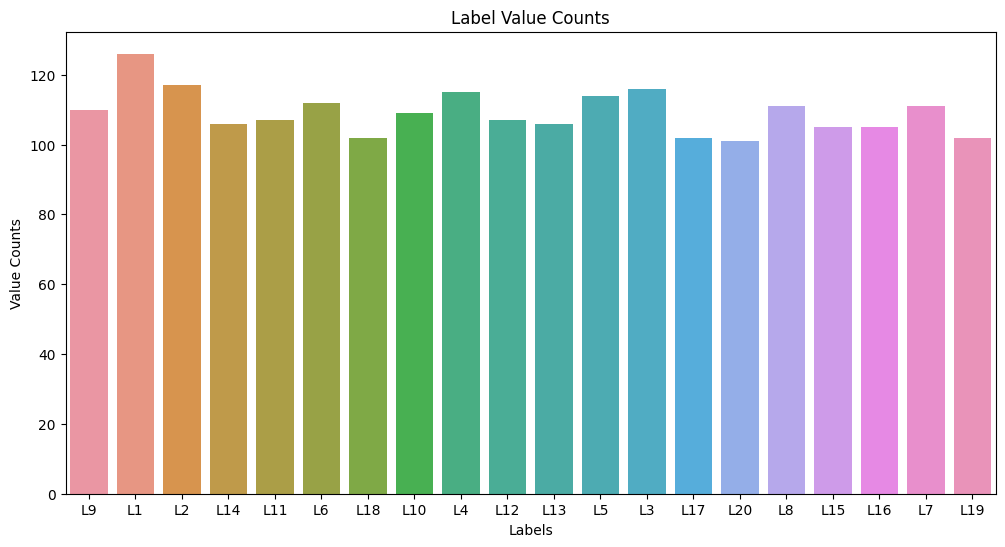

In [6]:
label_values = filtered_df["breed"].value_counts()
label_categories = {label: f'L{i}' for i, label in enumerate(label_values.index, 1)}
filtered_df['breed_mapped'] = filtered_df['breed'].map(label_categories)
plt.figure(figsize=(12, 6))
sns.countplot(x='breed_mapped', data=filtered_df)
plt.title('Label Value Counts')
plt.xlabel('Labels')
plt.ylabel('Value Counts')
plt.show()

In [7]:
path = "/content/train"
def load_and_preprocess_image(image_path, target_shape):
    img = plt.imread(image_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))
    return img

In [8]:
refactor_size = 128
resized_images = []
labels = []

for i in range(len(filtered_df)):
    image_filename = filtered_df["id"][i] + ".jpg"
    image_path = os.path.join(path, image_filename)
    img = load_and_preprocess_image(image_path, target_shape=(refactor_size, refactor_size))
    resized_images.append(img)
    labels.append(filtered_df["breed"][i])

labels = np.array(labels)
resized_images = np.asarray(resized_images)

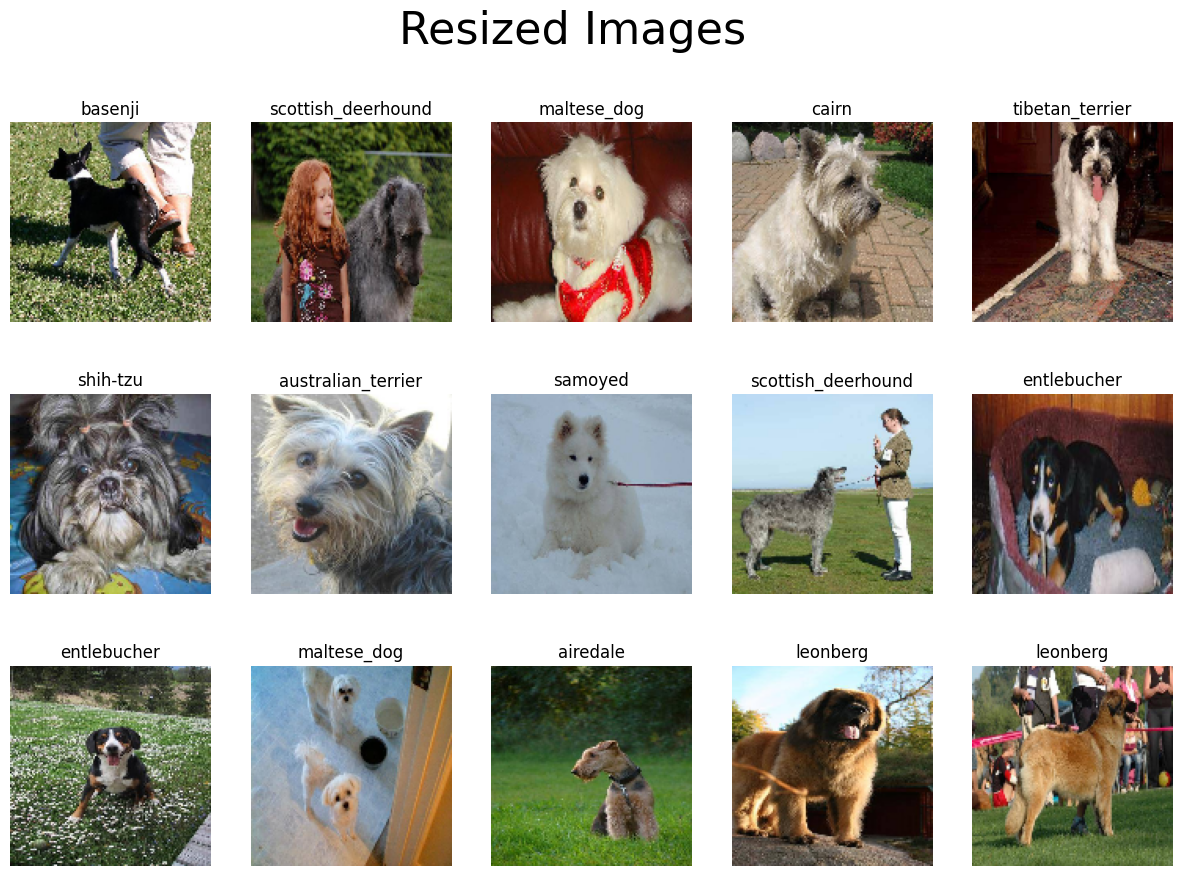

In [9]:
nrow = 3
ncol = 5
fig1 = plt.figure(figsize=(15, 10))
fig1.suptitle('Resized Images', size=32)
for i in range(15):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_images[i])
    plt.title(filtered_df["breed"][i])
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical")
])
augmented_images = data_augmentation(resized_images)
augmented_images = np.asarray(augmented_images)
augmented_images = augmented_images / 255.0

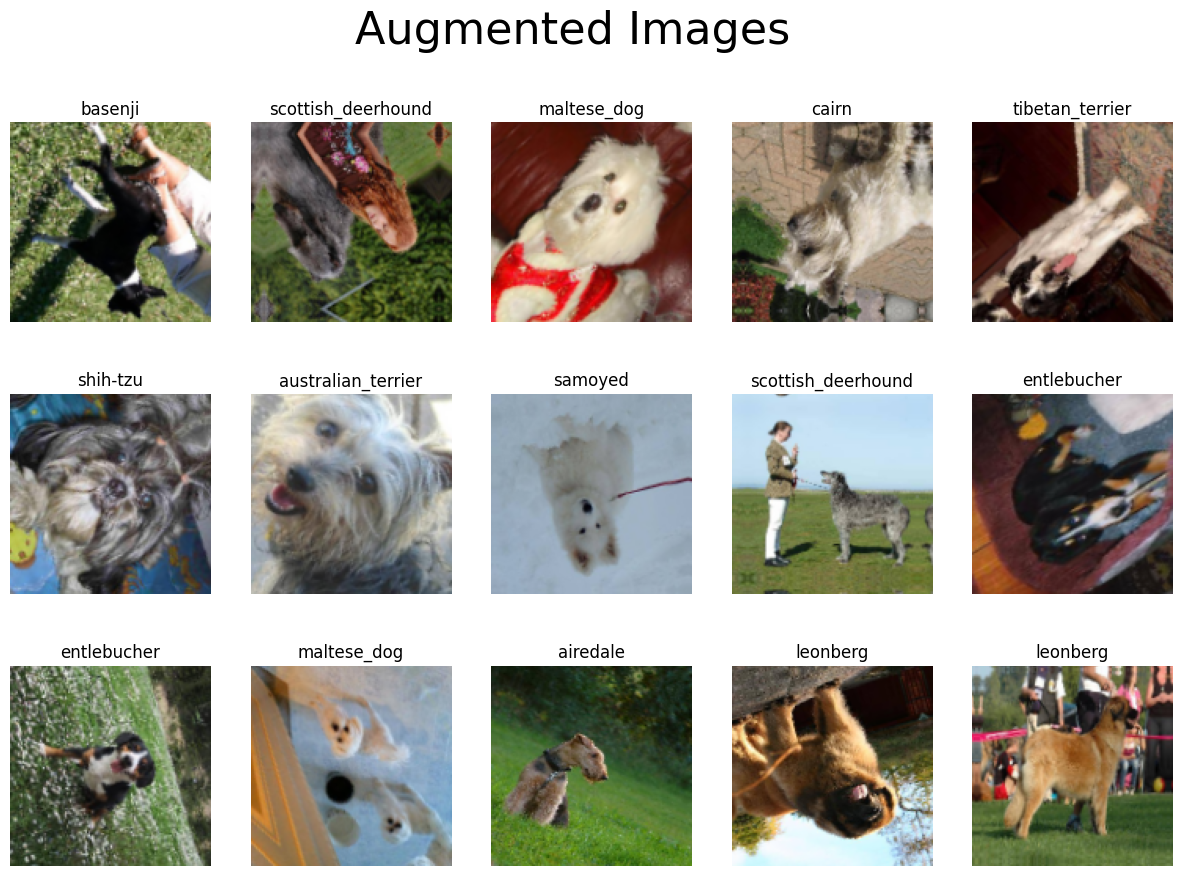

In [11]:
fig1 = plt.figure(figsize=(15, 10))
fig1.suptitle('Augmented Images', size=32)
for i in range(15):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(filtered_df["breed"][i])
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, labels, random_state=42)
print(X_train.shape, y_train.shape)

(1638, 128, 128, 3) (1638,)


In [13]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [14]:
model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])

In [15]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [16]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[checkpoint])

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 3.1080 - accuracy: 0.0464
Epoch 1: val_accuracy improved from -inf to 0.06410, saving model to best_model.h5
52/52 [==============================] - 18s 45ms/step - loss: 3.1080 - accuracy: 0.0464 - val_loss: 2.9959 - val_accuracy: 0.0641
Epoch 2/50
51/52 [============================>.] - ETA: 0s - loss: 2.9945 - accuracy: 0.0656
Epoch 2: val_accuracy improved from 0.06410 to 0.06593, saving model to best_model.h5
52/52 [==============================] - 2s 31ms/step - loss: 2.9948 - accuracy: 0.0653 - val_loss: 2.9605 - val_accuracy: 0.0659
Epoch 3/50
51/52 [============================>.] - ETA: 0s - loss: 2.9523 - accuracy: 0.0668
Epoch 3: val_accuracy improved from 0.06593 to 0.11905, saving model to best_model.h5
52/52 [==============================] - 2s 32ms/step - loss: 2.9518 - accuracy: 0.0672 - val_loss: 2.9064 - val_accuracy: 0.1190
Epoch 4/50
51/52 [============================>.] - ETA: 0s - loss: 2.92

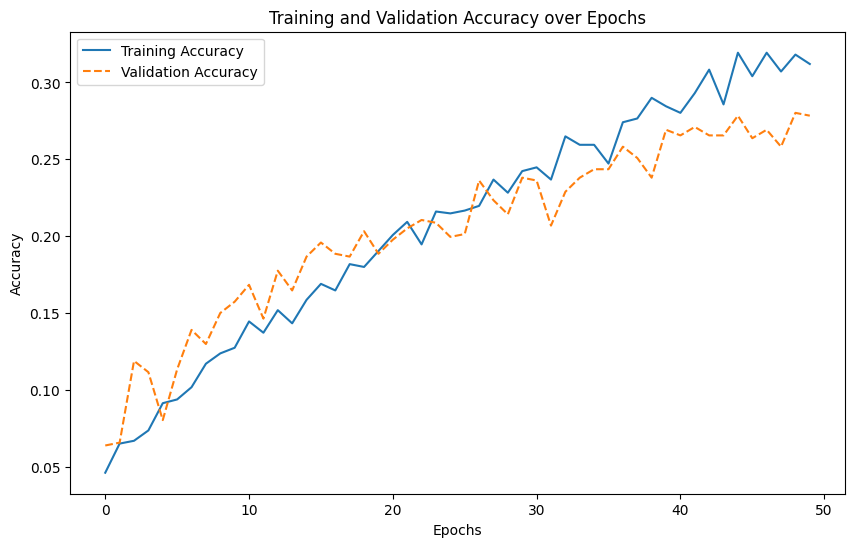

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
best_model = models.load_model('best_model.h5')

In [20]:
test_loss, best_test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

18/18 - 0s - loss: 2.2842 - accuracy: 0.2802 - 361ms/epoch - 20ms/step

Best Test Accuracy: 0.28021979331970215


In [21]:
best_predictions = best_model.predict(X_test)
best_predicted_classes = np.argmax(best_predictions, axis=1)

18/18 [==============================] - 0s 9ms/step


In [22]:
unique_labels = filtered_df["breed"].unique().tolist()

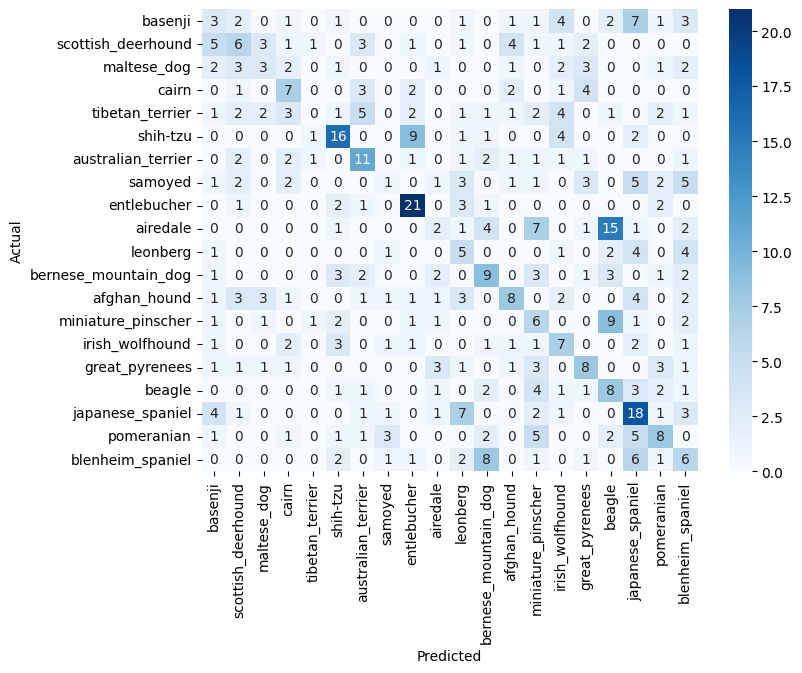

In [23]:
best_cm = confusion_matrix(y_test, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

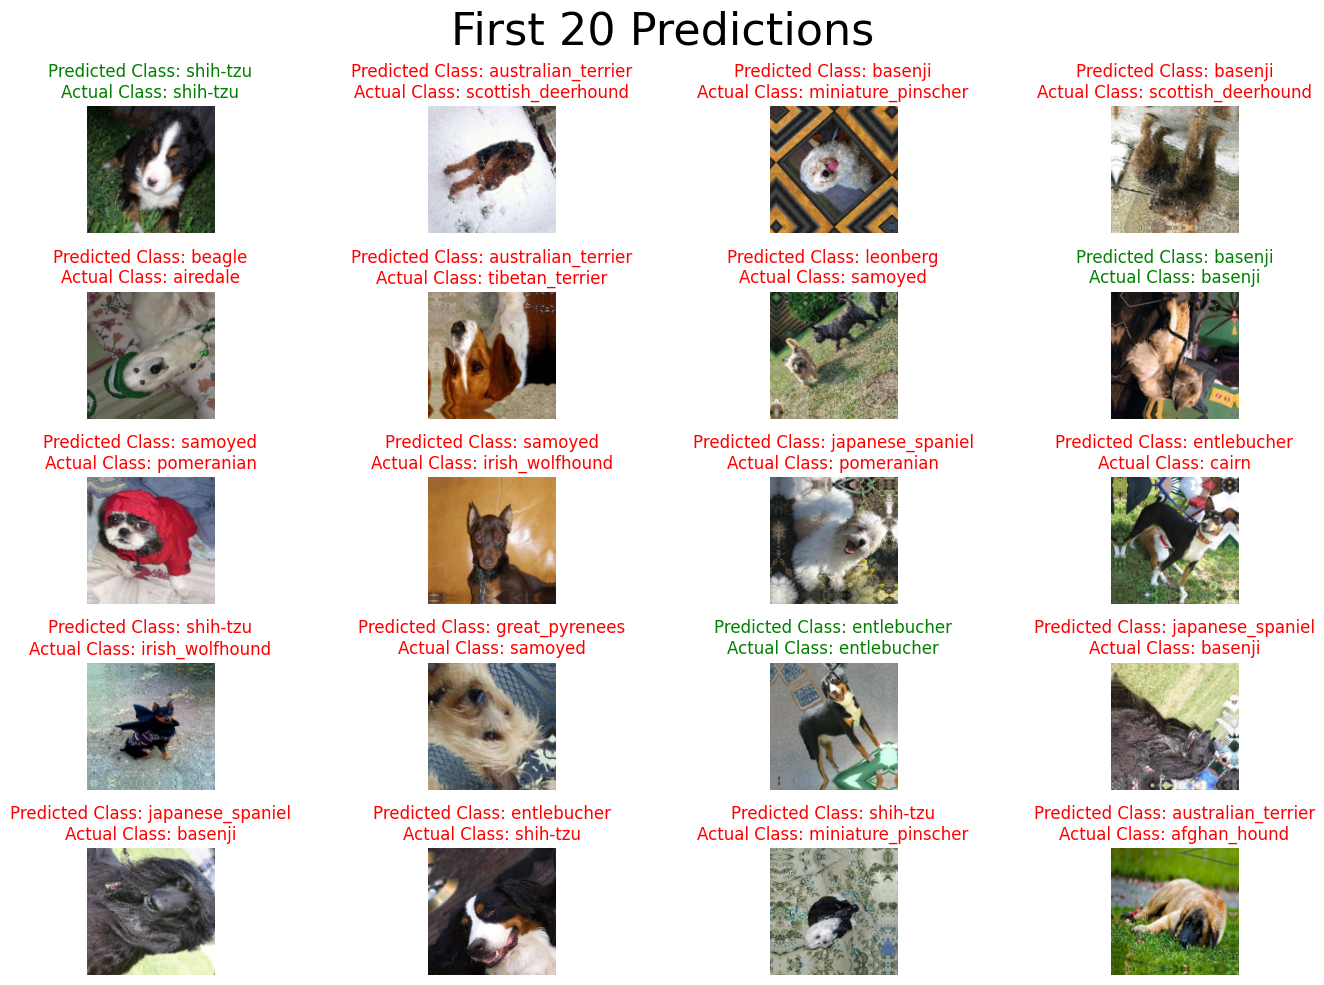

In [24]:
plt.figure(figsize=(15, 10))
plt.suptitle('First 20 Predictions', size=32)
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i])
    predicted_class_label = unique_labels[best_predicted_classes[i]]
    actual_class_label = unique_labels[y_test[i]]

    if best_predicted_classes[i] == y_test[i]:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f'Predicted Class: {predicted_class_label}\nActual Class: {actual_class_label}'
    plt.title(title, color=title_color)
    plt.axis('off')
    plt.grid(False)

plt.tight_layout()
plt.show()